<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - Neural Network <br>
<font color=696880 size=4>
    Alireza Belal
    
    
____


### Full Name : Mohammad Parham Bateni
### Student Number : 99105294
___

# Setup

# 0. Preparation

In this part, you will use a dataset related to COVID-19. Load your dataset using pandas.

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
covid_data = pd.read_csv('Covid Dataset.csv')
categorical_feature_mask = covid_data.dtypes == object
cateforical_cols = covid_data.columns[categorical_feature_mask].tolist()
le = LabelEncoder()
covid_data[cateforical_cols] = covid_data[cateforical_cols].apply(lambda col: le.fit_transform(col))
covid_data = covid_data.astype(float)

# Extract X and Y from the dataset
X_total = covid_data.iloc[:, 0:20].values
y_total = covid_data.iloc[:,20].values


#SPLIT THE DATA INTO TRAIN AND TEST DATA 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size = 0.3, random_state = 0)

---------------

# 1. DNN as nonlinear dimensionality reduction method (50 Points)

Autoencoder is an unsupervised artificial neural network that compresses the data to lower dimension and then reconstructs the input back. Autoencoder finds the representation of the data in a lower dimension by focusing more on the important features getting rid of noise and redundancy. It's based on Encoder-Decoder architecture, where encoder encodes the high-dimensional data to lower-dimension and decoder takes the lower-dimensional data and tries to reconstruct the original high-dimensional data.

![picture](https://drive.google.com/uc?id=1RTZwx4xL6zFV_nUENBgWlFKLKldPoyI-)

In the above Diagram, X is the input data, z is the lower-dimension representation of input X and X’ is the reconstructed input data. The mapping of higher to lower dimensions can be linear or non-linear depending on the choice of the activation function.

In this part you're gonna implement an autoencoder using Keras framework as dimensionally reduction module as explained [here](https://blog.keras.io/building-autoencoders-in-keras.html).
(It would be ok to use PyTorch as well.)
Reduce the dimension of the data to 2 dimensions and visualize the low-dimensional data.

In [285]:
# import necessary libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
import seaborn as sns

In [55]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [104]:
class Covid_Dataset(Dataset):
  def __init__(self,X,y):
    self.X=X
    self.y=y
  def __getitem__(self,index):
    return (self.X[index],self.y[index])
  def __len__(self):
    return len(self.X)

In [256]:
batch_size=16
train_dataset=Covid_Dataset(X_train,y_train)
test_dataset=Covid_Dataset(X_test,y_test)
train_dataloader=DataLoader(train_dataset,batch_size=16)
test_dataloader=DataLoader(test_dataset,batch_size=16)

In [122]:
# define layers (25 Points)
class AutoEncoder(nn.Module):
  def __init__(self,layers_shapes,activation_function=nn.ReLU):
    super().__init__()
    layers=nn.Sequential()
    for i,layer_shape in enumerate(layers_shapes):
      layers.add_module(f'{2*i}',nn.Linear(in_features=layer_shape[0],out_features=layer_shape[1],dtype=torch.float64))
      if i<len(layers_shapes)-1:
        layers.add_module(f'{2*i+1}',activation_function())
    self.layers_shapes=layers_shapes
    self.layers=layers
  def forward(self,x):
    out=x
    for layer in self.layers:
      try:
        out=layer(out)
      except:
        print(layer)
        print(out,out.shape)
        raise Exception
    return out
  def encode(self,x):
    out=x
    for layer in self.layers:
      is_latent_layer=isinstance(layer,nn.Linear) and layer.in_features==min(min(l[0],l[1]) for l in self.layers_shapes)
      if is_latent_layer:
        return out
      out=layer(out)
      
      
layers_shapes=[(20,10),(10,10),(10,5),(5,5),(5,2),(2,5),(5,5),(5,10),(10,10),(10,20)]
ae=AutoEncoder(layers_shapes).to(device)
print(ae)
# Test the encode function
# ae.encode(torch.tensor([1,1,2,3,1,0,1,2,0,3,2,10,3,16,16,41,21,12,10,0]).type(torch.float32))


AutoEncoder(
  (layers): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=5, bias=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=5, bias=True)
    (7): ReLU()
    (8): Linear(in_features=5, out_features=2, bias=True)
    (9): ReLU()
    (10): Linear(in_features=2, out_features=5, bias=True)
    (11): ReLU()
    (12): Linear(in_features=5, out_features=5, bias=True)
    (13): ReLU()
    (14): Linear(in_features=5, out_features=10, bias=True)
    (15): ReLU()
    (16): Linear(in_features=10, out_features=10, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10, out_features=20, bias=True)
  )
)


In [123]:
# train the model and reduce the dimension of the data (15 Points)
epochs=60
learning_rate=0.001
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(ae.parameters(),lr=learning_rate)
train_losses=[]
for epoch in range(epochs):
  epoch_loss=0
  for (X,y) in train_dataloader:
    pred=ae(X.to(device))
    loss=criterion(pred,X.to(device))
    epoch_loss+=loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  epoch_loss=epoch_loss/len(train_dataloader)
  print(f'************************\nEpoch{epoch+1}: Train MSE loss= {epoch_loss}')
  train_losses.append(epoch_loss)


************************
Epoch1: Train MSE loss= 0.27542604439696433
************************
Epoch2: Train MSE loss= 0.1930044417623838
************************
Epoch3: Train MSE loss= 0.19110079325524856
************************
Epoch4: Train MSE loss= 0.1903140544744748
************************
Epoch5: Train MSE loss= 0.18970469510311846
************************
Epoch6: Train MSE loss= 0.18920719758245394
************************
Epoch7: Train MSE loss= 0.1888092729939626
************************
Epoch8: Train MSE loss= 0.18850571864649684
************************
Epoch9: Train MSE loss= 0.18828768100048957
************************
Epoch10: Train MSE loss= 0.1880681534536645
************************
Epoch11: Train MSE loss= 0.18790452469230123
************************
Epoch12: Train MSE loss= 0.18776321983723535
************************
Epoch13: Train MSE loss= 0.18763800619348536
************************
Epoch14: Train MSE loss= 0.18752249636200183
************************
Epoch15:

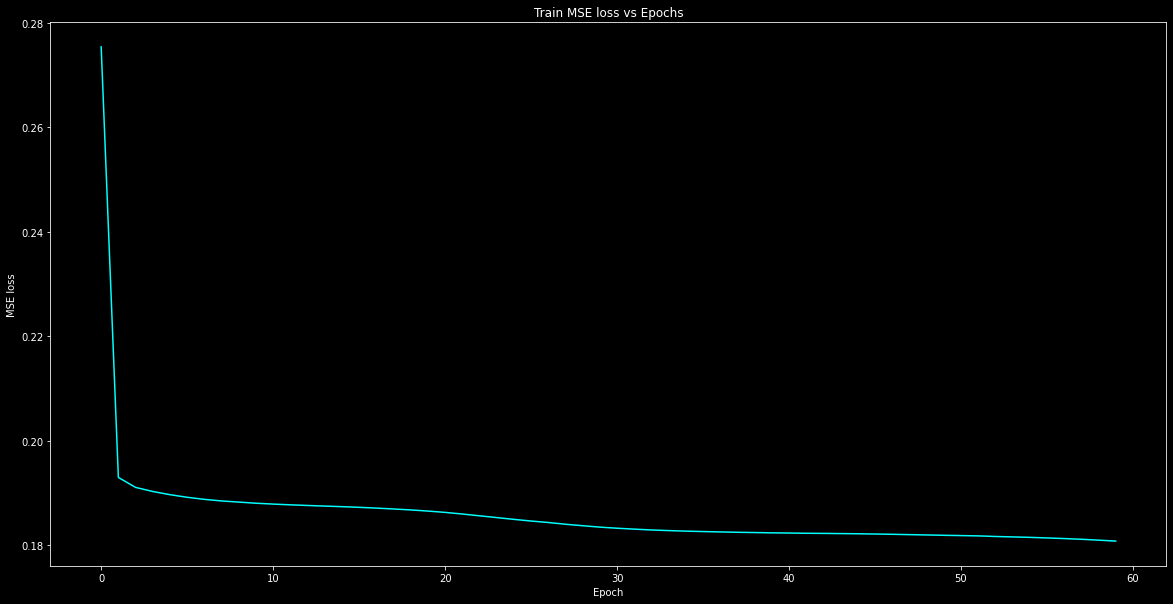

In [131]:
plt.style.use('dark_background')
plt.figure(figsize=(20,10))
plt.title('Train MSE loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.plot(np.arange(0,len(train_losses)),train_losses,color='cyan')
plt.show()

In [294]:
# Plot the encoded data (10 Points)

#First we encode train data
encoded_train_data_x=[]
encoded_train_data_y=[]
for (X,y) in train_dataloader:
  encoded_X=ae.encode(X)
  encoded_train_data_x.extend(encoded_X.tolist())
  encoded_train_data_y.extend(y.tolist())
encoded_train_data_x=np.array(encoded_train_data_x)
encoded_train_data_y=np.array(encoded_train_data_y)

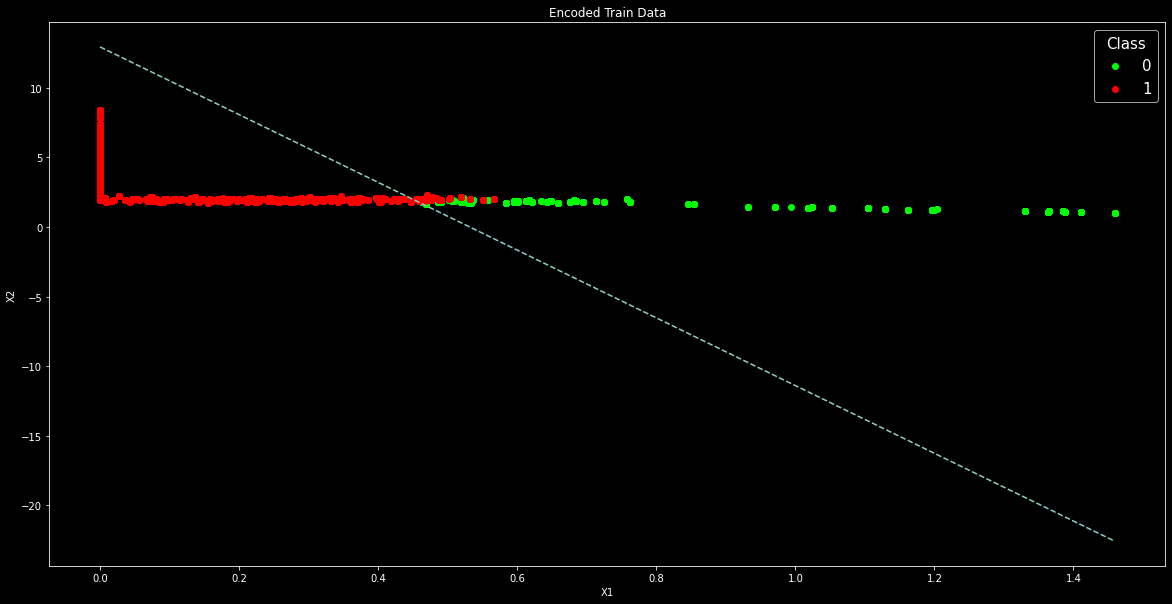

In [295]:
clf_train=LinearSVC(max_iter=5000)
clf_train.fit(encoded_train_data_x,encoded_train_data_y)
seperating_line_intercept=-clf_train.intercept_[0]/clf_train.coef_[0][1]
seperating_line_slope=-clf_train.coef_[0][0]/clf_train.coef_[0][1]
line_x=np.linspace(min(x[0] for x in encoded_train_data_x),max(x[0] for x in encoded_train_data_x),1000)
line_y=seperating_line_intercept+seperating_line_slope*line_x

colors=['lime','red']
encoded_train_data_x_0=encoded_train_data_x[encoded_train_data_y==0]
encoded_train_data_x_1=encoded_train_data_x[encoded_train_data_y==1]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.scatter([x[0] for x in encoded_train_data_x_0],[x[1] for x in encoded_train_data_x_0],color=colors[0],label='0')
ax.scatter([x[0] for x in encoded_train_data_x_1],[x[1] for x in encoded_train_data_x_1],color=colors[1],label='1')
ax.plot(line_x,line_y,linestyle='--')
ax.legend(title='Class',fontsize=15,title_fontsize=15)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Encoded Train Data')
plt.show()

As you can see in the figure above, the classes are almost linearly seperated in the encoded latent space for the training data.

In [292]:
# Now we encode the test data
encoded_test_data_x=[]
encoded_test_data_y=[]
for (X,y) in test_dataloader:
  encoded_X=ae.encode(X)
  encoded_test_data_x.extend(encoded_X.tolist())
  encoded_test_data_y.extend(y.tolist())
encoded_test_data_x=np.array(encoded_test_data_x)
encoded_test_data_y=np.array(encoded_test_data_y)

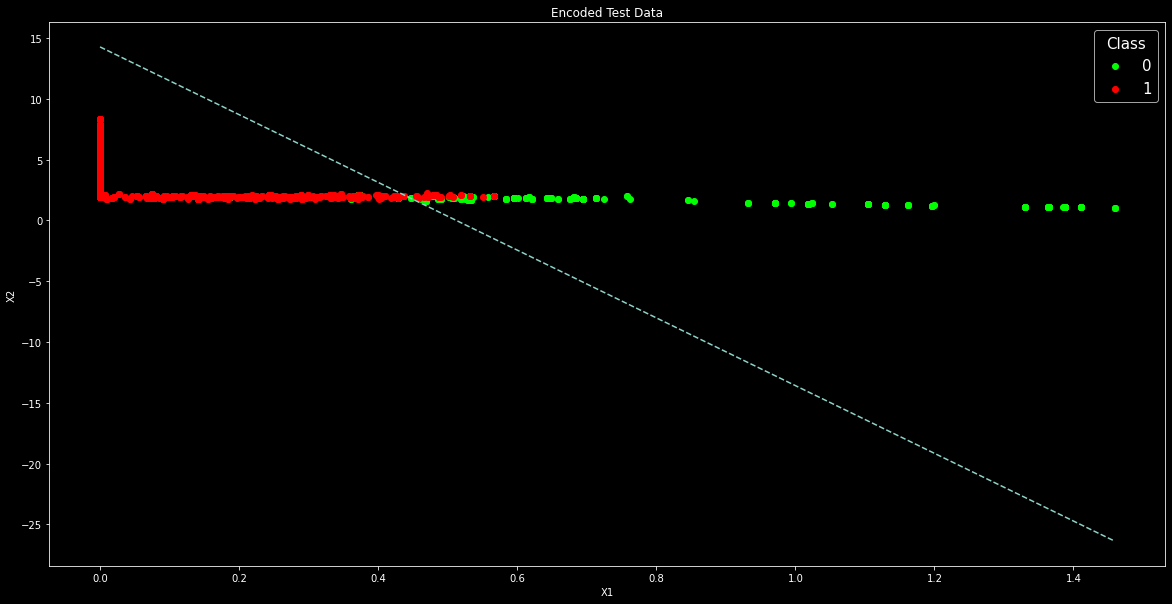

In [293]:
clf_test=LinearSVC(max_iter=5000)
clf_test.fit(encoded_test_data_x,encoded_test_data_y)
seperating_line_intercept=-clf_test.intercept_[0]/clf_test.coef_[0][1]
seperating_line_slope=-clf_test.coef_[0][0]/clf_test.coef_[0][1]
line_x=np.linspace(min(x[0] for x in encoded_test_data_x),max(x[0] for x in encoded_test_data_x),1000)
line_y=seperating_line_intercept+seperating_line_slope*line_x

colors=['lime','red']
encoded_test_data_x_0=encoded_test_data_x[encoded_test_data_y==0]
encoded_test_data_x_1=encoded_test_data_x[encoded_test_data_y==1]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.scatter([x[0] for x in encoded_test_data_x_0],[x[1] for x in encoded_test_data_x_0],color=colors[0],label='0')
ax.scatter([x[0] for x in encoded_test_data_x_1],[x[1] for x in encoded_test_data_x_1],color=colors[1],label='1')
ax.plot(line_x,line_y,linestyle='--')
ax.legend(title='Class',fontsize=15,title_fontsize=15)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Encoded Test Data')
plt.show()

The classes are almost linearly seperated in the encoded latent space as well in the test data too.
<br>
Even We can use the support vector classifier we fitted to the encoded training data to classify the test data. In the following cell you can see that this leads to an accuracy of 95 percent for this classifier.

confusion_matrix:
[[ 273.   33.]
 [  45. 1280.]]
The accuracy of model on test data: 0.952


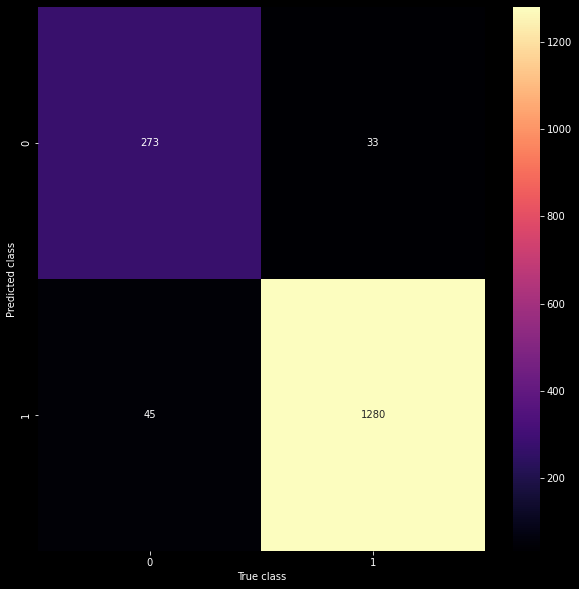

In [296]:
confusion_matrix=np.zeros((2,2))
for X,y in test_dataloader:
  encoded_X=ae.encode(X).tolist()
  pred=clf_train.predict(encoded_X)
  for i in range(len(pred)):
    confusion_matrix[int(pred[i]),int(y[i].item())]+=1
print('confusion_matrix:')
print(confusion_matrix)
print(f'The accuracy of model on test data: {confusion_matrix.trace()/np.sum(confusion_matrix):.3f}')
fig, ax = plt.subplots(figsize=(10,10))
heatmap=sns.heatmap(confusion_matrix,cmap='magma',annot=True,ax=ax,fmt='.0f')
ax.set_xlabel('True class')
ax.set_ylabel('Predicted class')
plt.show()

So we implemented an auto encoder which encodes the covid data with 20 features into a latent space with only 2 features. Then we fit a linear model(support vector classifier) to the reduced latent space and then we used this linear model to classify new data (test data) by first encoding the test data and then using the linear classifier. The final result was interesting since we got to an accuracy of 95 percent for a classification task by only using two features out of 20 features of data :)